In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Auction Algorithm

In [228]:
def _random_er_bipartite_graph(n, m, p = 0.25, weighted = False, directed=False, low = 0.0, high = 1.0):
        """Random bipartite graph-based flow network."""
        mat = np.random.binomial(1, p, size = (n, m))
        
        if weighted:
            weights = np.random.uniform(low = low, high = high, size = (n, m))
            mat = np.multiply(mat, weights)
            
        return np.array(mat)

In [226]:
def auction_algorithm(A, verbose=False):
    n, m = A.shape
    values = np.copy(A)
    eps = 1 / (n + 1)
    
    unassigned = set(np.arange(n))
    owner = np.zeros(m) - 1
    alg = 0
    trajectory = [alg]
    
    def _compute_bids(values, unassigned):
        items = np.argmax(values, axis=1)
        v = np.max(values, axis=1)
        B = np.copy(values)
        B[np.arange(values.shape[0]), items] = 0
        w = np.max(B, axis=1)
        bids = v - w + eps
        bid_mat = np.zeros((n, m))
        bid_mat[list(unassigned), items] = bids
        return bid_mat
    
    while unassigned:
        if np.all(values[list(unassigned)] <= 0):
            break
        bid_matrix = _compute_bids(values[list(unassigned), :], unassigned)
        assignments = np.argmax(bid_matrix, axis=0)
        increments = np.max(bid_matrix, axis=0)
        
        if verbose:
            print(f"Unassigned: {list(unassigned)}")
            print(f"Bid matrix:\n {bid_matrix}")
            print(f"Assignments: {assignments}")
            
        for i in range(m):
            candidate = assignments[i]
            if candidate in unassigned and bid_matrix[candidate, i] != 0:
                prev_owner = int(owner[i])
                if prev_owner != -1:
                    unassigned.add(prev_owner)
                    alg -= A[prev_owner, i]
                    
                owner[i] = candidate
                unassigned.remove(candidate)
                values[:, i] -= increments[i]
                alg += A[candidate, i]
        trajectory.append(alg)
        
    return owner, trajectory


In [2]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

def plot_trajectories(trajectories, xmin, xmax, ymin, ymax):
    fig = plt.figure(figsize=(10,8))
    y, error = tolerant_mean(trajectories)
    plt.plot(np.arange(len(y)), y, color='green')
    plt.fill_between(np.arange(len(y)), y-error, y+error,
        alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    plt.xlim(xmin-0.5,xmax+0.5)
    plt.ylim(ymin, ymax)
    plt.hlines(y=1, xmin=xmin, xmax=xmax, color='r', linestyle='--', label='OPT')
    plt.legend()
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xticks(np.arange(xmax + 1))
    plt.show()


## Message passing round
Each buyer sents a message with a bid to their most favored good:
<div>
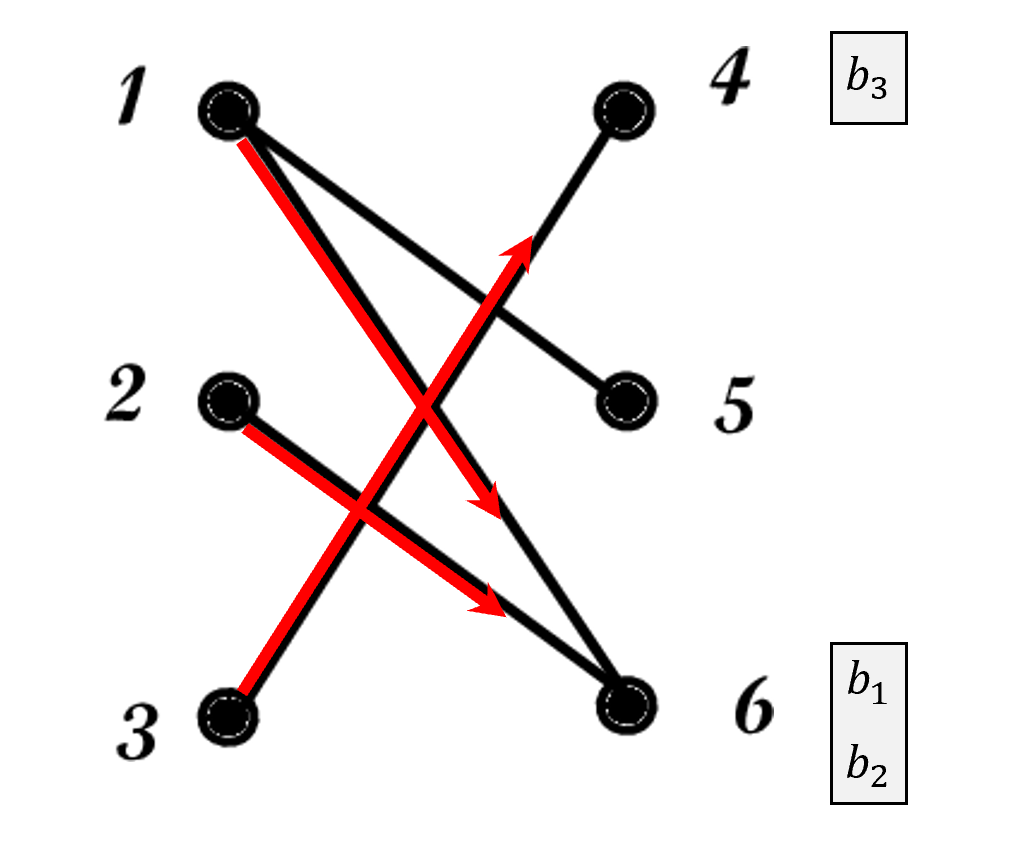
</div>


### Experiment 1: varying p

In [358]:
num_trials = 250
experiment_specs = [(64, 64, 0.25), (64, 64, 0.5), (64, 64, 0.75), (64, 64, 1)]
avg_trajectories = []

for spec in experiment_specs:
    trajectories = []
    lb = 0
    ub = 0
    for i in range(num_trials):
        vals = _random_er_bipartite_graph(*spec, weighted=True)
        row_ind, col_ind = linear_sum_assignment(-vals)
        opt = vals[row_ind, col_ind].sum()
        _, trajectory = auction_algorithm(vals, verbose=False)
        trajectories.append(np.array(trajectory) / opt)
        lb += (opt - 1) / num_trials
        ub += (opt) / num_trials
    print(f"ALG bound {(spec)}: [{round(lb/ub, 4)}, {1}]")

    avg_trajectories.append(tolerant_mean(trajectories)[0].data)

ALG bound (64, 64, 0.25): [0.9827, 1]
ALG bound (64, 64, 0.5): [0.9836, 1]
ALG bound (64, 64, 0.75): [0.9838, 1]


C:\Users\awiku\Anaconda3\lib\site-packages\numpy\ma\core.py:4283: RuntimeWarning: invalid value encountered in multiply
  getdata(other)))


ALG bound (64, 64, 1): [0.984, 1]


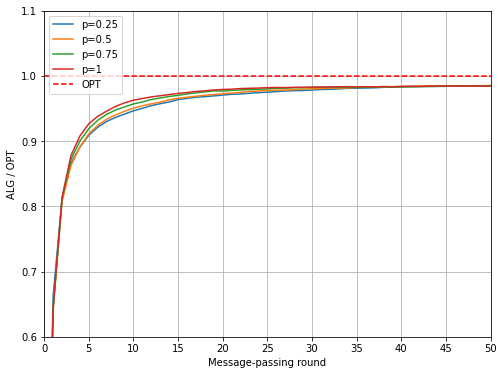

In [359]:
fig = plt.figure(figsize=(8,6))
for i in range(len(avg_trajectories)):
    plt.plot(range(len(avg_trajectories[i])), avg_trajectories[i], label=f"p={experiment_specs[i][2]}")
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xlim(1, 50)
    plt.ylim(0.6, 1.1)
plt.hlines(y=1, xmin=0, xmax=50, color='r', linestyle='--', label='OPT')
plt.xticks(np.arange(0, 51, 5))
plt.grid()
plt.legend()
plt.show()

### Experiment 2: Varying n

In [354]:
num_trials = 250
experiment_specs = [(48, 64, 1), (64, 64, 1), (80, 64, 1)]
avg_trajectories = []

for spec in experiment_specs:
    trajectories = []
    lb = 0
    ub = 0
    for i in range(num_trials):
        vals = _random_er_bipartite_graph(*spec, weighted=True)
        row_ind, col_ind = linear_sum_assignment(-vals)
        opt = vals[row_ind, col_ind].sum()
        _, trajectory = auction_algorithm(vals, verbose=False)
        trajectories.append(np.array(trajectory) / opt)
        lb += (opt - 1) / num_trials
        ub += (opt) / num_trials
    print(f"ALG bound {(spec)}: [{round(lb/ub, 4)}, {1}]")

    avg_trajectories.append(tolerant_mean(trajectories)[0].data)

ALG bound (48, 64, 1): [0.9787, 1]
ALG bound (64, 64, 1): [0.984, 1]
ALG bound (80, 64, 1): [0.9841, 1]


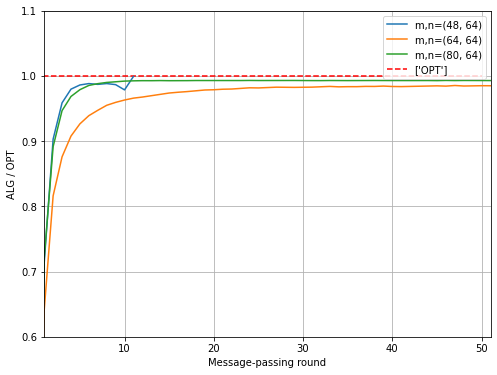

In [355]:
fig = plt.figure(figsize=(8,6))
for i in range(len(avg_trajectories)):
    plt.plot(range(len(avg_trajectories[i])), avg_trajectories[i], label=f"m,n={experiment_specs[i][0], experiment_specs[i][1]}")
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xlim(1, 51, 5)
    plt.ylim(0.6, 1.1)
plt.hlines(y=[1], xmin=0, xmax=50, color=['r'], linestyle='--', label=['OPT'])
plt.legend()
plt.grid()
plt.show()

## Min-sum Algorithm


<div>
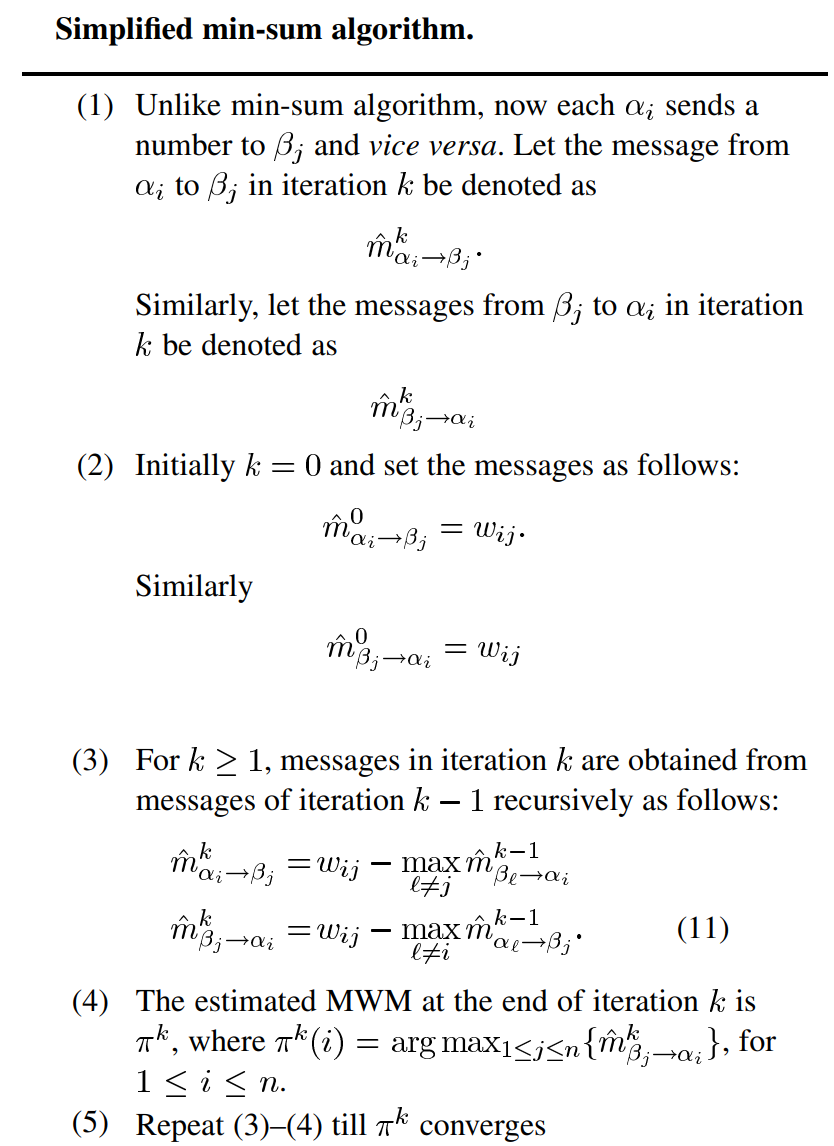
</div>

In [416]:
A = _random_er_bipartite_graph(10, 10, 1, weighted=True)
A

array([[0.6063626 , 0.76987771, 0.25282995, 0.38200718, 0.43644504,
        0.27036388, 0.51816631, 0.18581527, 0.93897262, 0.85003071],
       [0.00515918, 0.76829225, 0.89084951, 0.36580073, 0.37745587,
        0.72581936, 0.53234464, 0.68813118, 0.32938505, 0.01217573],
       [0.78416172, 0.630803  , 0.55517193, 0.13136403, 0.08985022,
        0.75837035, 0.03372696, 0.3490988 , 0.28756822, 0.52210835],
       [0.4016498 , 0.55731141, 0.39041762, 0.91185155, 0.1526141 ,
        0.30386413, 0.43577803, 0.82125534, 0.97036294, 0.96938892],
       [0.68404406, 0.13555492, 0.20495486, 0.91431402, 0.68922389,
        0.27288343, 0.92578029, 0.96736613, 0.57414508, 0.35308004],
       [0.2057917 , 0.50694961, 0.44942999, 0.42700629, 0.92382944,
        0.27887498, 0.90521596, 0.69319803, 0.1148228 , 0.90371174],
       [0.09468278, 0.24942329, 0.73039711, 0.5131939 , 0.45030159,
        0.54082583, 0.30967662, 0.06940454, 0.91084679, 0.97250168],
       [0.10696362, 0.88465205, 0.7888131

In [434]:
def simplified_min_sum(A):
    def _compute_cost(assign):
        cost = 0
        seen = set()
        for i in range(len(assign)):
            if assign[i] not in seen:
                cost += A[assign[i], i]
                seen.add(assign[i])
        return cost

    M_f = np.copy(A); M_b = np.copy(A.T)
    n, m = A.shape

    trajectory = [0]
    for k in range(30):
        prev_M_f = np.copy(M_f)
        for j in range(m):
            mask = np.ones(m, dtype=bool)
            mask[j] = 0
            M_f[:, j] = A[:, j] - np.max(M_b[mask, :], axis=0)

        for i in range(n):
            mask = np.ones(n, dtype=bool)
            mask[i] = 0
            M_b[:, i] = A.T[:, i] - np.max(prev_M_f[mask, :], axis=0)
            
        trajectory.append(_compute_cost(np.argmax(M_f, axis=0)))
    
    return trajectory
    

In [435]:
num_trials = 100
experiment_specs = [(48, 64, 1), (64, 64, 1), (80, 64, 1)]
avg_trajectories = []

for spec in experiment_specs:
    trajectories = []
    lb = 0
    ub = 0
    for i in range(num_trials):
        vals = _random_er_bipartite_graph(*spec, weighted=True)
        row_ind, col_ind = linear_sum_assignment(-vals)
        opt = vals[row_ind, col_ind].sum()
        trajectory = simplified_min_sum(vals)
        trajectories.append(np.array(trajectory) / opt)
        lb += (opt - 1) / num_trials
        ub += (opt) / num_trials
    print(f"ALG bound {(spec)}: [{round(lb/ub, 4)}, {1}]")

    avg_trajectories.append(tolerant_mean(trajectories)[0].data)

ALG bound (48, 64, 1): [0.9787, 1]
ALG bound (64, 64, 1): [0.984, 1]
ALG bound (80, 64, 1): [0.9841, 1]


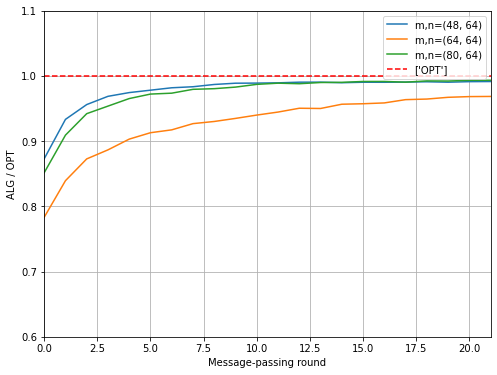

In [436]:
fig = plt.figure(figsize=(8,6))
for i in range(len(avg_trajectories)):
    plt.plot(range(len(avg_trajectories[i])), avg_trajectories[i], label=f"m,n={experiment_specs[i][0], experiment_specs[i][1]}")
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xlim(0, 21, 5)
    plt.ylim(0.6, 1.1)
plt.hlines(y=[1], xmin=0, xmax=50, color=['r'], linestyle='--', label=['OPT'])
plt.legend()
plt.grid()
plt.show()

In [392]:
A

array([[0.7792347 , 0.97385908, 0.54859292],
       [0.66588057, 0.80969236, 0.88566737],
       [0.17418632, 0.00835154, 0.09437248],
       [0.91780274, 0.54167697, 0.20594911],
       [0.52331408, 0.38691372, 0.46228216]])

## GNN

In [3]:
import clrs
import numpy as np
import jax
import jax.numpy as jnp

import pprint

2023-05-07 18:51:32.879717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Experiment 1: varying p
Note: had to change the experiment parameters to avoid excessive compute times

num_trials -> 40
64x64 -> 32x32

no n/m distinction for the moment

had to divide opt from scipy by 2?

In [105]:
def train(num_trials, test_len, p, model = None):
    n = test_len // 2
    rng = np.random.RandomState(1234)
    rng_key = jax.random.PRNGKey(rng.randint(2**32))

    train_sampler, spec = clrs.build_sampler(
        name='auction_matching',
        num_samples=100,
        length=16,
        weighted=True,
        p=(p,)) # number of nodes

    test_sampler, spec = clrs.build_sampler(
        name='auction_matching',
        num_samples=num_trials, # TODO set back to more
        length=test_len,
        weighted=True,
        p=(p,)) # testing on much larger

    def _iterate_sampler(sampler, batch_size):
        while True:
            yield sampler.next(batch_size)

    train_sampler = _iterate_sampler(train_sampler, batch_size=32)
    test_sampler = _iterate_sampler(test_sampler, batch_size=40)

    if model is None:

        processor_factory = clrs.get_processor_factory('mpnn', use_ln=True, nb_triplet_fts=0)


        model_params = dict(
            processor_factory=processor_factory, # contains the processor_factory
            hidden_dim=32,
            encode_hints=True,
            decode_hints=True,
            #decode_diffs=False,
            #hint_teacher_forcing_noise=1.0,
            hint_teacher_forcing=1.0,
            use_lstm=False,
            learning_rate=0.001,
            checkpoint_path='/tmp/checkpt',
            freeze_processor=False, # Good for post step
            dropout_prob=0.5,
        )

        dummy_trajectory = next(train_sampler)

        model = clrs.models.BaselineModel(
            spec=spec,
            dummy_trajectory=dummy_trajectory,
            **model_params
        )

        model.init(dummy_trajectory.features, 1234) # 1234 is a random seed

        # Don't care about evaluation here
        step = 0

        print("training")
        while step <= 200:
            feedback, test_feedback = next(train_sampler), next(test_sampler)
            rng_key, new_rng_key = jax.random.split(rng_key) # jax needs new random seed at step
            cur_loss = model.feedback(rng_key, feedback) # loss is contained in model somewhere
            rng_key = new_rng_key
            if step % 10 == 0:
                predictions_val, _ = model.predict(rng_key, feedback.features)
                out_val = clrs.evaluate(feedback.outputs, predictions_val)
                predictions, _ = model.predict(rng_key, test_feedback.features)
                out = clrs.evaluate(test_feedback.outputs, predictions)
                print(f'step = {step} | loss = {cur_loss} | val_acc = {out_val["score"]} | test_acc = {out["score"]}') # here, val accuracy is actually training accuracy, not great but is example
            step += 1
        print("done training")
    else:
        print("model specified: bypassing training")


    test_feedback = next(test_sampler)
    predictions, hints = model.predict(rng_key, test_feedback.features, return_hints = True, return_all_outputs = True)

    predictions = predictions['owners'].data

    # TODO: could be ::-n then reverse too but then don't have the final value
    predictions = predictions[::n]


    lb = 0
    ub = 0
    trajectories = []
    for trial in range(num_trials):
        vals = test_feedback.features.inputs[1].data[trial]
        row_ind, col_ind = linear_sum_assignment(-vals)
        opt = vals[row_ind, col_ind].sum()
        print(f"------ opt scipy: {opt}")
        # TODO why do I have to do this??
        opt = opt/2

        trajectory = matching_value(test_feedback, predictions, trial)
        trajectories.append(np.array(trajectory) / opt)
        lb += (opt - 1) / num_trials
        ub += (opt) / num_trials

    print(f"ALG bound {(test_len, p)}: [{round(lb/ub, 4)}, {1}]")
    return trajectories, model





In [106]:
# Matching value computation

def matching_value(samples, predictions, trial):
    features = samples.features
    gt_matchings = samples.outputs[0].data
    # inputs for the matrix A are at index 1 (see spec.py)
    data = features.inputs[1].data
    masks = features.inputs[3].data

    trajectory = []

    # Iterating over all the "iterations" (steps in the algo)
    max_weight = compute_greedy_matching_weight(trial, data, masks, gt_matchings[trial])
    for i in range(predictions.shape[0]):
        predicted_matching = predictions[i][trial]
        preds_weight = compute_greedy_matching_weight(trial, data, masks, predicted_matching)
        trajectory.append(preds_weight)
        print(f"opt: {max_weight}, greedy: {preds_weight}, ratio: {preds_weight / max_weight}")

        assert preds_weight <= max_weight

    return trajectory

def compute_greedy_matching_weight(i, data, masks, matching):
    matching_weight = 0
    A = data[i]
    buyers_mask = masks[i]
    n = int(np.sum(buyers_mask))
    goods_mask = 1 - buyers_mask



    # Only consider the matching values for consumers
    matching = np.where(goods_mask == 1, matching, -1)

    for buyer in range(n):
        if buyer in matching:
            # If several goods point to the same buyer, keep the one with maximum weight
            matching_weight += np.max(A[buyer, matching == buyer])

    return matching_weight


In [111]:
num_trials = 40
experiment_specs = [(64, 0.25), (64, 0.5), (64, 0.75), (64, 1)]
# experiment_specs = [(64, 0.25)]
avg_trajectories = []

model = None
for spec in experiment_specs:
    model = None
    test_len, p = spec
    trajectories, model = train(num_trials, test_len, p, model = model)
    avg_trajectories.append(tolerant_mean(trajectories)[0].data)

training
step = 0 | loss = 7.209134578704834 | val_acc = 0.14453125 | test_acc = 0.0011718750465661287
step = 10 | loss = 4.1988067626953125 | val_acc = 0.33203125 | test_acc = 0.012500000186264515
step = 20 | loss = 2.4816553592681885 | val_acc = 0.35546875 | test_acc = 0.008593750186264515
step = 30 | loss = 1.655460000038147 | val_acc = 0.25390625 | test_acc = 0.009765625
step = 40 | loss = 1.284665584564209 | val_acc = 0.251953125 | test_acc = 0.02070312574505806
step = 50 | loss = 1.0949616432189941 | val_acc = 0.35546875 | test_acc = 0.06132812425494194
step = 60 | loss = 0.9890626668930054 | val_acc = 0.720703125 | test_acc = 0.328125
step = 70 | loss = 0.9346339106559753 | val_acc = 0.8515625 | test_acc = 0.573437511920929
step = 80 | loss = 0.8919762372970581 | val_acc = 0.8828125 | test_acc = 0.616406261920929
step = 90 | loss = 0.8501437902450562 | val_acc = 0.876953125 | test_acc = 0.6753906607627869
step = 100 | loss = 0.8516446352005005 | val_acc = 0.85546875 | test_acc =

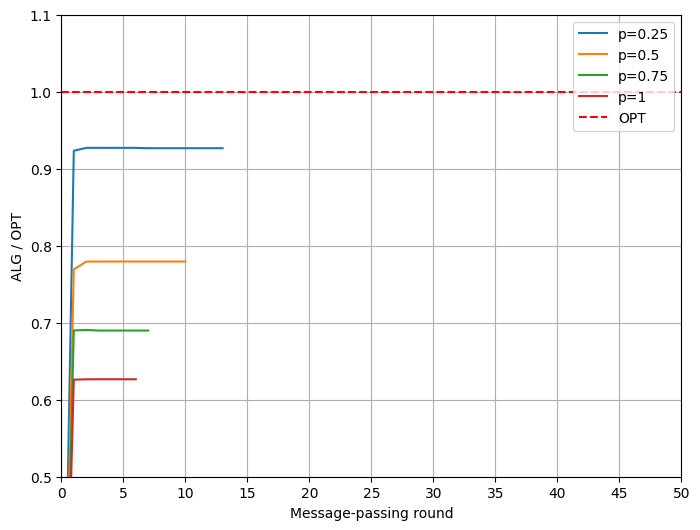

In [110]:
fig = plt.figure(figsize=(8,6))
for i in range(len(avg_trajectories)):
    plt.plot(range(len(avg_trajectories[i])), avg_trajectories[i], label=f"p={experiment_specs[i][1]}")
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xlim(1, 50)
    plt.ylim(0.5, 1.1)
plt.hlines(y=1, xmin=0, xmax=50, color='r', linestyle='--', label='OPT')
plt.xticks(np.arange(0, 51, 5))
plt.grid()
plt.legend()
plt.show()



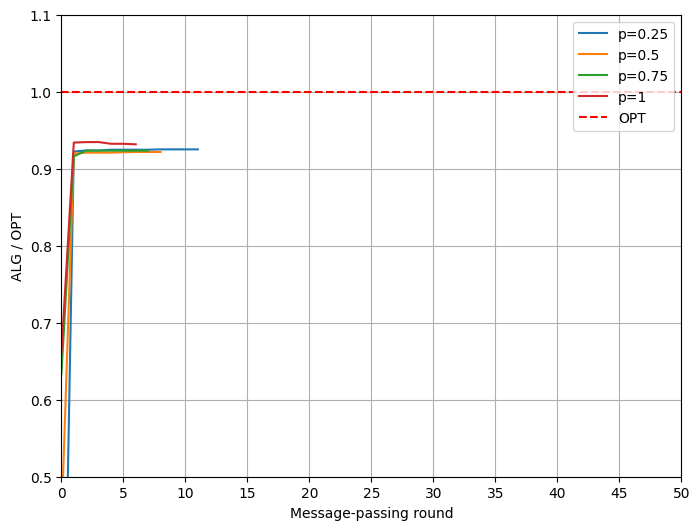

In [112]:
fig = plt.figure(figsize=(8,6))
for i in range(len(avg_trajectories)):
    plt.plot(range(len(avg_trajectories[i])), avg_trajectories[i], label=f"p={experiment_specs[i][1]}")
    plt.xlabel('Message-passing round')
    plt.ylabel('ALG / OPT')
    plt.xlim(1, 50)
    plt.ylim(0.5, 1.1)
plt.hlines(y=1, xmin=0, xmax=50, color='r', linestyle='--', label='OPT')
plt.xticks(np.arange(0, 51, 5))
plt.grid()
plt.legend()
plt.show()
